<h1><b>Import Libraries<b><h1>

In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
import tensorflow
import keras
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import time
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.svm import SVR, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

<h1><b>Input Data from Yahoo Finance<b><h1>

In [7]:
import yfinance as yf

ticker = 'IBN'
start_date = '2022-01-01'
end_date = '2023-11-30'

DF = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [8]:
DF

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,20.340000,20.469999,20.270000,20.350000,20.063496,5106500
2022-01-04,20.620001,20.639999,20.480000,20.530001,20.240961,5842300
2022-01-05,20.950001,21.240000,20.830000,20.879999,20.586033,8925300
2022-01-06,20.879999,21.200001,20.870001,21.150000,20.852234,8427700
2022-01-07,21.270000,21.740000,21.250000,21.700001,21.394489,9931800
...,...,...,...,...,...,...
2023-11-22,22.219999,22.270000,22.110001,22.120001,22.120001,3400000
2023-11-24,22.230000,22.360001,22.200001,22.340000,22.340000,2252400
2023-11-27,22.230000,22.290001,22.110001,22.230000,22.230000,3942200


<h1><b>Plotting closing price for every day<b><h1>

Text(0, 0.5, 'Value')

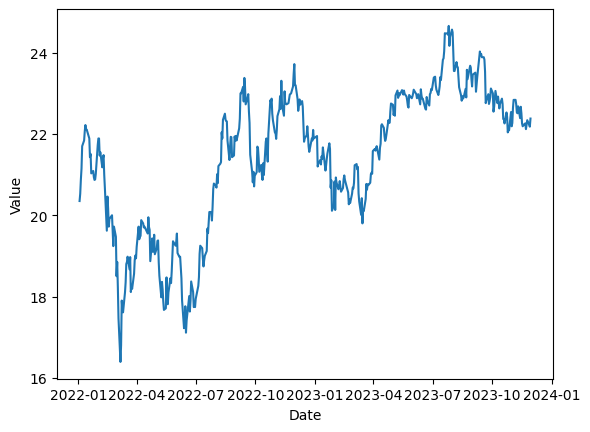

In [10]:
plt.plot(DF.Close)
plt.xlabel('Date')
plt.ylabel('Value')

<h1><b>Define Function<b></h1>

In [11]:
#creating datasets from the dataframe, make data stationary:
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

def create_dataset_percentage_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]/dataset[i+window_size-1,0]-1
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

def create_dataset_difference_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]-dataset[i+window_size-1,0]
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

#regression to classification:
def y_classifier(array, threshold):
    classes = []
    for i in range(len(array)):
        if array[i,0] > threshold:
            classes.append(1)
        elif array[i,0] < -1*threshold:
            classes.append(-1)
        else:
            classes.append(0)
    return np.asarray(classes)

#defining moving averages:
def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

#defining some metrics
def rms(y, pred):
    temp = 0
    if len(y) != len(pred):
        return False
    else:
        for i in range(len(y)):
            temp += (y[i][0] - pred[i][0])**2
        return temp/len(y)

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)+0.0000000001))

def mae(A, F):
    return 1/len(A) * np.sum(np.abs(F - A))

#autocorrelation benchmark:
def benchmark(y, look_forward):
    Y_hat = []
    Y_real = []
    for i in range(2*look_forward, len(y)):
        a = np.mean(y[i-2*look_forward:i-look_forward,0])
        Y_hat.append(a)
        Y_real.append(y[i,0])
    return (np.asarray(Y_real), np.asarray(Y_hat))

def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

def plot(y_train, prediction_train,y_test, prediction_test):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, prediction_train)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Train')


    plt.subplot(1, 2, 2)
    plt.scatter(y_test, prediction_test)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Test')
    plt.show()

    plt.figure(figsize=(15,8))
    plt.subplot(2, 1, 1)
    plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
    plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
    plt.grid()
    plt.legend()
    plt.title('Train')
    plt.subplots_adjust(hspace = 0.4)

    plt.subplot(2, 1, 2)
    plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
    plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
    plt.grid()
    plt.legend()
    plt.title('Test')

#this function changes 1D y array to an array with 3 features that is used for softmax
def y_softmax(array):
    lst = []
    for i in range(len(array)):
        if array[i] == 1:
            lst.append([1,0,0])
        elif array[i] == 0:
            lst.append([0,1,0])
        else:
            lst.append([0,0,1])
    return np.asarray(lst)


def softmaxifier(array):
    zeros = [0, 0, 0]
    pred = []
    for i in range(len(array)):
        j = np.argmax(array[i])
        temp = [0,0,0]
        temp[j] = 1
        pred.append(temp)
    return pred

#this function changes 3D y array with 3 features that was generated by softmax to an 1D array for confusion matrix
def desoftmaxer(array):
    lst = []
    for i in range(len(array)):
        if np.argmax(array[i]) == 0:
            lst.append(1)
        elif np.argmax(array[i]) == 1:
            lst.append(0)
        else:
            lst.append(-1)
    return (np.asarray(lst))
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.set_random_seed(seed_value)
    from keras import backend as K
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

#split x and y to test and train that are devisible to batch_size
def test_train_split(x, y, batch_size, train_ratio):
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

<h1><b>Creating Features<b></h1>

In [12]:
df = DF.Close
df = df.dropna(axis=0, how='any')

#making moving averages
v_10 = SMA(DF.Volume, 10)
v_20 = SMA(DF.Volume, 20)
open_close = (DF.Close/DF.Open - 1).tolist()
high_low = (DF.High/DF.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = DF.Volume.tolist()
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10,
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])

#removing all rows with 0 in them
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

#making differences as features
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

<ipython-input-12-e45bebd0ac9c>:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)


<h1><b>Visualisation<b></h1>

,spot,pct_day,vol,open_close,high_low,v10,v20,spot_EMA,spot_20SMA,spot_50SMA,spot_100SMA,10_100_SMA,20_50_SMA
0,18.990000,0.020419,10342700,0.008497,0.020822,0.377304,0.261166,0.029620,0.029966,0.004560,-0.029786,-0.070097,-0.024667
1,19.360001,0.019484,6871200,0.014144,0.015191,-0.064308,-0.128205,0.038219,0.049124,0.023580,-0.010291,-0.060901,-0.024347
2,19.250000,-0.005682,6606400,0.000520,0.015231,-0.078419,-0.154617,0.024959,0.042993,0.017474,-0.015093,-0.052238,-0.024467
3,19.350000,0.005195,11709200,-0.005141,0.014583,0.542015,0.423422,0.023396,0.048468,0.022025,-0.009064,-0.046858,-0.025221
4,19.549999,0.010336,6352000,0.011905,0.018229,-0.158782,-0.214246,0.026226,0.058817,0.031956,0.002281,-0.037195,-0.025369


<Figure size 640x480 with 0 Axes>

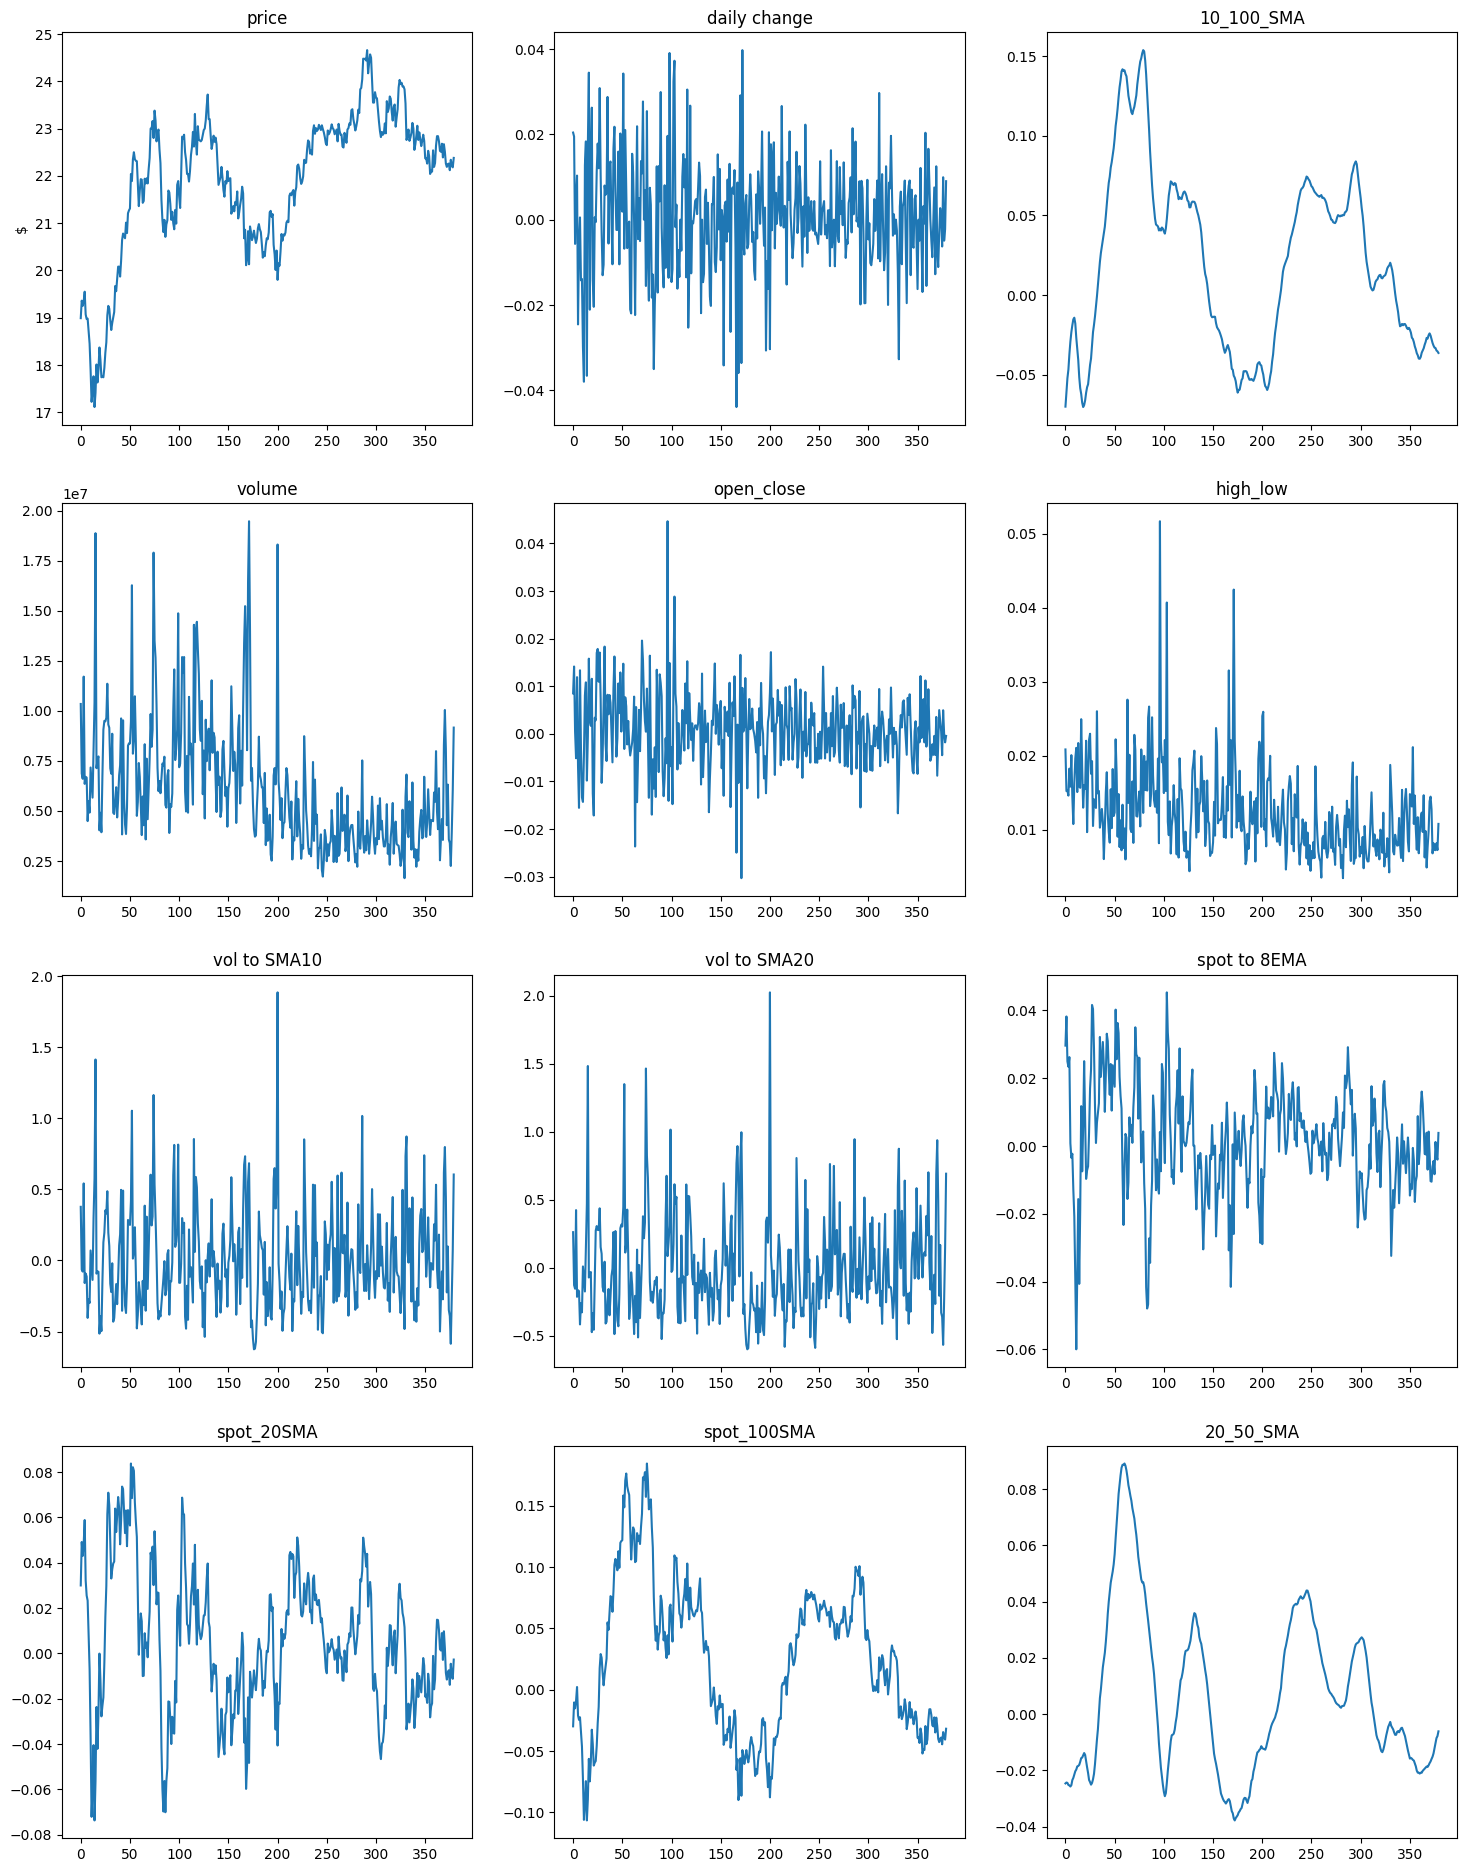

In [13]:
fig = plt.figure()
plt.figure(figsize=(18,14))

plt.subplot(4, 3, 1)
plt.plot(MAs.spot)
plt.ylabel('$')
plt.title('price')

plt.subplot(4, 3, 2)
plt.plot(MAs.pct_day)
plt.title('daily change')

plt.subplot(4, 3, 3)
plt.plot(MAs['10_100_SMA'])
plt.title('10_100_SMA')

plt.subplot(4, 3, 4)
plt.plot(MAs.vol)
plt.title('volume')
plt.subplots_adjust(top = 1.4)

plt.subplot(4, 3, 5)
plt.plot(MAs.open_close)
plt.title('open_close')

plt.subplot(4, 3, 6)
plt.plot(MAs.high_low)
plt.title('high_low')

plt.subplot(4, 3, 7)
plt.plot(MAs.v10)
plt.title('vol to SMA10')

plt.subplot(4, 3, 8)
plt.plot(MAs.v20)
plt.title('vol to SMA20')

plt.subplot(4, 3, 9)
plt.plot(MAs.spot_EMA)
plt.title('spot to 8EMA')

plt.subplot(4, 3, 10)
plt.plot(MAs.spot_20SMA)
plt.title('spot_20SMA')

plt.subplot(4, 3, 11)
plt.plot(MAs.spot_100SMA)
plt.title('spot_100SMA')

plt.subplot(4, 3, 12)
plt.plot(MAs['20_50_SMA'])
plt.title('20_50_SMA')
MAs.head(5)

<h1><b>Opening Price Prediction<b><h1>

In [14]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [15]:
import yfinance as yf
import datetime

ticker = 'IBN'
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2023, 11, 30)

df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [16]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,20.340000,20.469999,20.270000,20.350000,20.063496,5106500
2022-01-04,20.620001,20.639999,20.480000,20.530001,20.240961,5842300
2022-01-05,20.950001,21.240000,20.830000,20.879999,20.586033,8925300
2022-01-06,20.879999,21.200001,20.870001,21.150000,20.852234,8427700
2022-01-07,21.270000,21.740000,21.250000,21.700001,21.394489,9931800
...,...,...,...,...,...,...
2023-11-22,22.219999,22.270000,22.110001,22.120001,22.120001,3400000
2023-11-24,22.230000,22.360001,22.200001,22.340000,22.340000,2252400
2023-11-27,22.230000,22.290001,22.110001,22.230000,22.230000,3942200


In [17]:
df.shape

(480, 6)

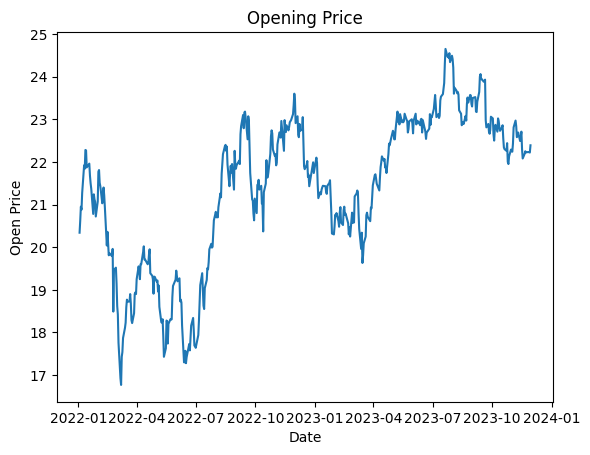

In [18]:
plt.figure()
plt.title('Opening Price')
plt.plot(df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.show()

In [19]:
data=df.filter(['Open'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up

training_data_len = math.ceil(len(dataset)*.8)

#print(dataset)
training_data_len

384

In [20]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [21]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.45304569, 0.48857878, 0.53045695, 0.5215735 , 0.57106605,
       0.65355332, 0.64340105, 0.69923868, 0.69796962, 0.64720824,
       0.65862934, 0.62309649, 0.60025381, 0.58375646, 0.50888333,
       0.56725886, 0.55203056, 0.54568524, 0.50126894, 0.54568524,
       0.63451783, 0.63959385, 0.60152288, 0.5913706 , 0.54060922,
       0.56852792, 0.58756341, 0.56345166, 0.52791882, 0.41497472,
       0.45558382, 0.42258887, 0.38578672, 0.39213204, 0.38324883,
       0.4048222 , 0.21827405, 0.34263949, 0.34898481, 0.30203038,
       0.23477165, 0.20939084, 0.1256345 , 0.02030455, 0.        ,
       0.08375633, 0.0977158 , 0.13959397, 0.1700508 , 0.18527909,
       0.23096445, 0.25380713, 0.24746181, 0.24873087, 0.27030449,
       0.24238579, 0.19289348, 0.18401003, 0.21319803, 0.27030449])]
[0.2753807496703895]



In [22]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [23]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(324, 60, 1)

<h1><b>Model Training<b></h1>

In [32]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [33]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=25)

Epoch 1/25
324/324 [==============================] - 10s 21ms/step - loss: 0.0109
Epoch 2/25
324/324 [==============================] - 9s 28ms/step - loss: 0.0057
Epoch 3/25
324/324 [==============================] - 8s 25ms/step - loss: 0.0043
Epoch 4/25
324/324 [==============================] - 8s 24ms/step - loss: 0.0034
Epoch 5/25
324/324 [==============================] - 9s 27ms/step - loss: 0.0027
Epoch 6/25
324/324 [==============================] - 7s 21ms/step - loss: 0.0025
Epoch 7/25
324/324 [==============================] - 9s 26ms/step - loss: 0.0025
Epoch 8/25
324/324 [==============================] - 7s 21ms/step - loss: 0.0021
Epoch 9/25
324/324 [==============================] - 9s 26ms/step - loss: 0.0022
Epoch 10/25
324/324 [==============================] - 7s 21ms/step - loss: 0.0019
Epoch 11/25
324/324 [==============================] - 9s 27ms/step - loss: 0.0020
Epoch 12/25
324/324 [==============================] - 8s 24ms/step - loss: 0.0019
Epoch 13/25


<h1><b>Testing and Validating Model<b><h1>

In [35]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [36]:
#Convert the data to a numpy array

x_test=np.array(x_test)

In [37]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [38]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

3/3 [==============================] - 2s 21ms/step


In [39]:
#Get root mean squared error(RMSE)

rmse =np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.4337705572446187

<ipython-input-40-c8a3c18753aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


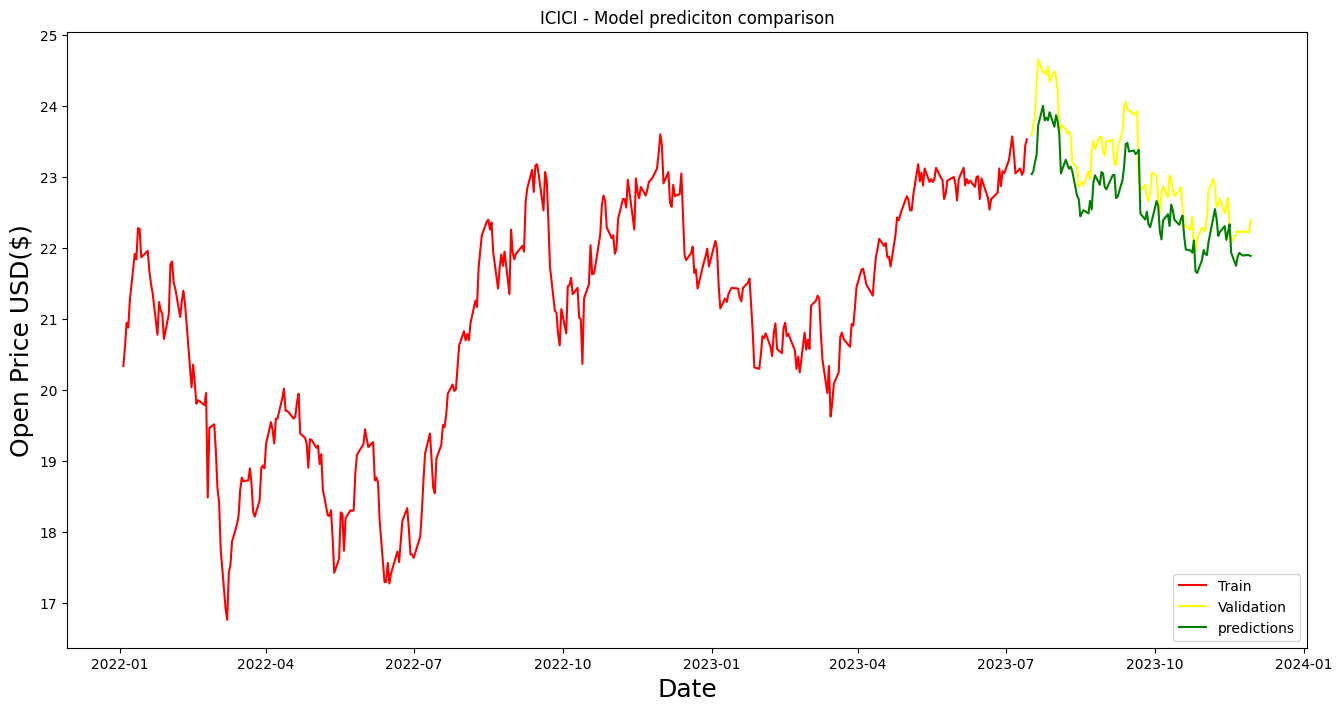

In [40]:
#plot the data

train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('ICICI - Model prediciton comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train['Open'] , color='red')
plt.plot(valid['Open'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.show()

In [41]:
#Show the valid and predicted prices

valid.tail(30)

,Open,predictions
Date,,
2023-10-18,22.559999,22.458158
2023-10-19,22.340000,22.168125
2023-10-20,22.299999,21.980139
2023-10-23,22.260000,21.964500
2023-10-24,22.440001,21.933928
2023-10-25,22.000000,22.106920
2023-10-26,21.950001,21.673410
2023-10-27,22.129999,21.648531
2023-10-30,22.290001,21.831553


<h1><b>Getting Predictions for Tomorrow<b></h1>

In [43]:
#Get the quote
ticker = 'IBN'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 24ms/step
Opening Price of IBN tomorrow:[[22.049623]]


<h1><b>Getting Predictions for 60 days from now<b></h1>

In [45]:
import yfinance as yf
import numpy as np

# Assuming you already have the 'model' and 'scaler' objects defined

# Get historical stock data
ticker = 'IBN'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

# Extract 'Open' prices
new_df = stock_quote.filter(['Open'])

# Take the last 60 days of 'Open' prices and scale them
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to store predicted prices
predicted_prices = []

# Number of days to forecast (adjust as needed)
forecast_days = 60

# Loop through the forecast period
for _ in range(forecast_days):
    # Reshape the data for prediction
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get predicted scaled price
    pred_price = model.predict(X_test)

    # Undo the scaling
    pred_price = scaler.inverse_transform(pred_price)

    # Append the predicted price to the list
    predicted_prices.append(pred_price[0, 0])

    # Update last_60_days for the next iteration
    last_60_days = np.append(last_60_days[1:], pred_price, axis=0)
    last_60_days_scaled = scaler.transform(last_60_days)

# Print the predicted prices for the next 2 months
for i, price in enumerate(predicted_prices, 1):
    print(f'Day {i}: Predicted Opening Price of {ticker}: {price}')


[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 34ms/step
Day 1: Predicted Opening Price of IBN: 22.049623489379883
Day 2: Predicted Opening Price of IBN: 21.71393585205078
Day 3: Predicted Opening Price of IBN: 21.41366195678711
Day 4: Predicted Opening Price of IBN: 21.156322479248047
Day 5: Predicted Opening Price of IBN: 20.93735694885254
Day 6: Predicted Opening Price of IBN: 20.749210357666016
Day 7: Predicted Opening Price of IBN: 20.58445930480957
Day 8: Predicted Opening Price of IBN: 20.43720245361328
Day 9: Predicted Opening Price of IBN: 20.30329704284668
Day 10: Predicted Opening Price of IBN: 20.180065155029297
Day 11: Predicted Opening Price of IBN: 20.06586265563965
Day 12: Predicted Opening Price of IBN: 19.95969009399414
Day 13: Predicted Opening Price of IBN: 19.860891342163086
Day 14: Predicted Opening Price of IBN: 19.768970489501953
Day 15: Predicted Opening Price of IBN: 19.683490753173828
Day 16: Pre

<h1><b>Closing Price Prediction<b></h1>

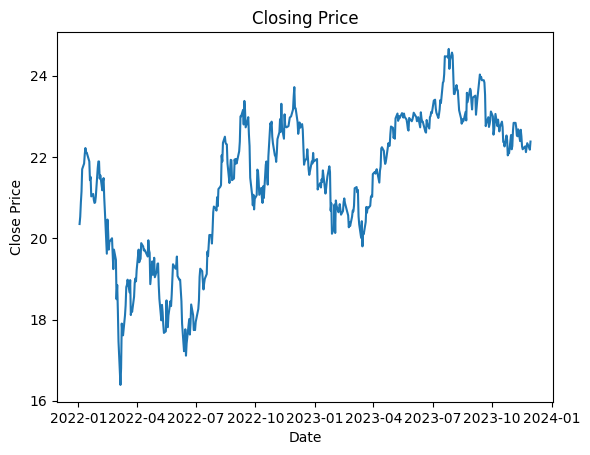

In [48]:
plt.figure()
plt.title('Closing Price')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [49]:
data=df.filter(['Close'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up

training_data_len = math.ceil(len(dataset)*.8)


#print(dataset)
training_data_len

384

In [50]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.47883927],
       [0.50060472],
       [0.54292618],
       [0.57557436],
       [0.64207994],
       [0.65900852],
       [0.68681983],
       [0.70495763],
       [0.69044748],
       [0.6916567 ],
       [0.66505438],
       [0.60943176],
       [0.61910527],
       [0.56106421],
       [0.56831929],
       [0.55018149],
       [0.54171719],
       [0.54292618],
       [0.559855  ],
       [0.64570736],
       [0.66505438],
       [0.66505438],
       [0.6142684 ],
       [0.62394191],
       [0.57920201],
       [0.60580411],
       [0.61547761],
       [0.55743656],
       [0.51753331],
       [0.39056847],
       [0.4921402 ],
       [0.45707382],
       [0.40266019],
       [0.42563486],
       [0.43651758],
       [0.39177746],
       [0.34461913],
       [0.40266019],
       [0.37243044],
       [0.25513912],
       [0.2974608 ],
       [0.22249094],
       [0.12938327],
       [0.        ],
       [0.04957676],
       [0.18258768],
       [0.15356716],
       [0.147

In [51]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.47883927, 0.50060472, 0.54292618, 0.57557436, 0.64207994,
       0.65900852, 0.68681983, 0.70495763, 0.69044748, 0.6916567 ,
       0.66505438, 0.60943176, 0.61910527, 0.56106421, 0.56831929,
       0.55018149, 0.54171719, 0.54292618, 0.559855  , 0.64570736,
       0.66505438, 0.66505438, 0.6142684 , 0.62394191, 0.57920201,
       0.60580411, 0.61547761, 0.55743656, 0.51753331, 0.39056847,
       0.4921402 , 0.45707382, 0.40266019, 0.42563486, 0.43651758,
       0.39177746, 0.34461913, 0.40266019, 0.37243044, 0.25513912,
       0.2974608 , 0.22249094, 0.12938327, 0.        , 0.04957676,
       0.18258768, 0.15356716, 0.1475213 , 0.20677157, 0.23700132,
       0.29141472, 0.2974608 , 0.31318017, 0.27569535, 0.31197095,
       0.20798079, 0.22611859, 0.2176543 , 0.26239419, 0.30350666])]
[0.31680782275819674]



In [52]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [53]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(324, 60, 1)

<h1><b>Model Training<b></h1>

In [54]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [55]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [56]:
#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=25 )

Epoch 1/25
324/324 [==============================] - 14s 30ms/step - loss: 0.0115
Epoch 2/25
324/324 [==============================] - 11s 33ms/step - loss: 0.0054
Epoch 3/25
324/324 [==============================] - 8s 25ms/step - loss: 0.0042
Epoch 4/25
324/324 [==============================] - 9s 26ms/step - loss: 0.0034
Epoch 5/25
324/324 [==============================] - 7s 22ms/step - loss: 0.0026
Epoch 6/25
324/324 [==============================] - 9s 26ms/step - loss: 0.0025
Epoch 7/25
324/324 [==============================] - 7s 23ms/step - loss: 0.0025
Epoch 8/25
324/324 [==============================] - 8s 25ms/step - loss: 0.0022
Epoch 9/25
324/324 [==============================] - 8s 26ms/step - loss: 0.0019
Epoch 10/25
324/324 [==============================] - 7s 23ms/step - loss: 0.0017
Epoch 11/25
324/324 [==============================] - 9s 27ms/step - loss: 0.0020
Epoch 12/25
324/324 [==============================] - 7s 22ms/step - loss: 0.0020
Epoch 13/25

<h1><b>Testing and Validating Model<b></h1>

In [57]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [58]:
#Convert the data to a numpy array

x_test=np.array(x_test)

In [59]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [60]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

3/3 [==============================] - 1s 23ms/step


In [61]:
#Get root mean squared error(RMSE)

rmse =np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.15245970090230307

<ipython-input-62-85c54dd68431>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


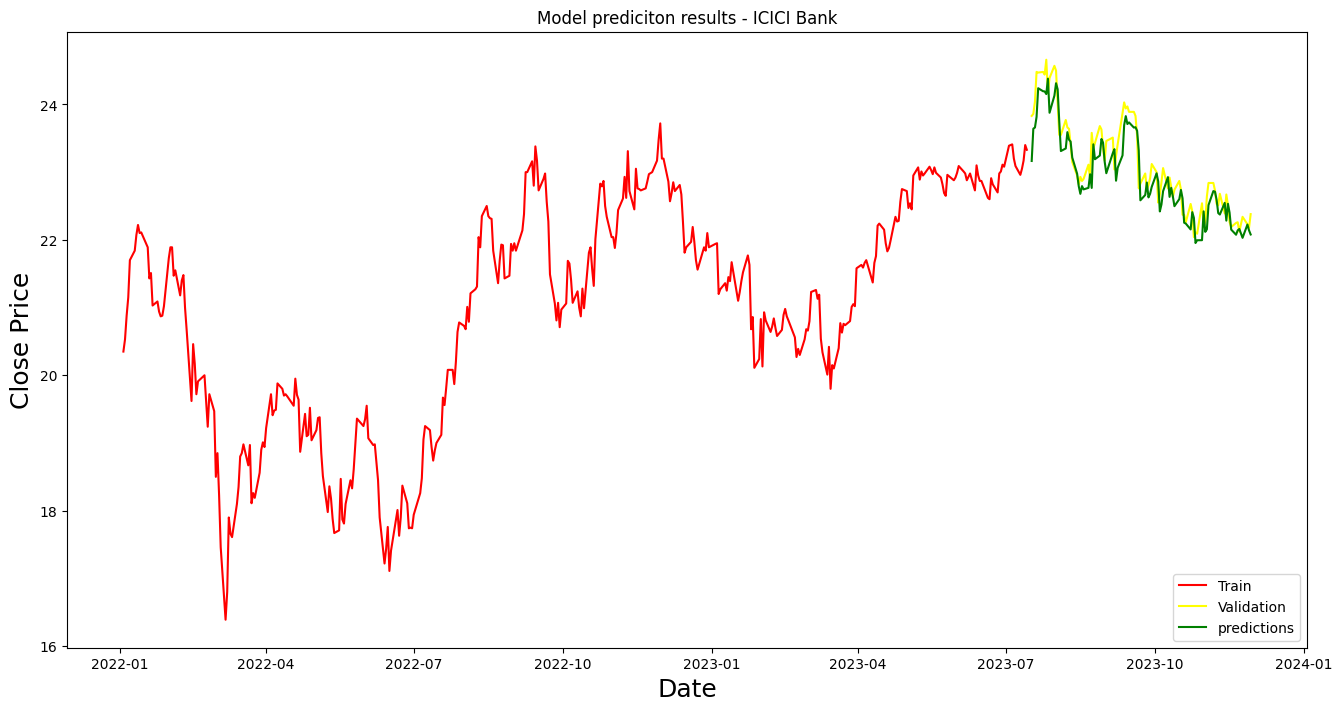

In [62]:
#plot the data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model prediciton results - ICICI Bank')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'] , color='red')
plt.plot(valid['Close'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.show()

In [63]:
#Show the valid and predicted prices

valid.tail(20)

,Close,predictions
Date,,
2023-11-01,22.270000,22.117739
2023-11-02,22.639999,22.154757
2023-11-03,22.840000,22.512667
2023-11-06,22.840000,22.720272
2023-11-07,22.730000,22.711069
2023-11-08,22.530001,22.591969
2023-11-09,22.510000,22.394951
2023-11-10,22.680000,22.373728
2023-11-13,22.389999,22.546104


<h1><b>Getting Predictions for Tomorrow<b></h1>

In [65]:
#Get the quote
ticker = 'IBN'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

new_df=stock_quote.filter(['Close'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Price of {ticker} tomorrow:{pred_price}')

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 1s 1s/step
Price of IBN tomorrow:[[22.263771]]


<h1><b>Getting Predictions for 60 days from now<b></h1>

In [66]:
import yfinance as yf
import numpy as np

# Assuming you have the necessary imports and the 'model' and 'scaler' objects are defined

# Get the historical stock data
ticker = 'IBN'
start_date = '2022-01-01'
end_date = '2023-11-30'
stock_quote = yf.download(ticker, start=start_date, end=end_date)

# Extract 'Close' prices
new_df = stock_quote.filter(['Close'])

# Take the last 60 days of 'Close' prices and scale them
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to store predicted prices
predicted_prices = []

# Number of days to forecast (adjust as needed)
forecast_days = 60

# Loop through the forecast period
for _ in range(forecast_days):
    # Reshape the data for prediction
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get predicted scaled price
    pred_price = model.predict(X_test)

    # Undo the scaling
    pred_price = scaler.inverse_transform(pred_price)

    # Append the predicted price to the list
    predicted_prices.append(pred_price[0, 0])

    # Update last_60_days for the next iteration
    last_60_days = np.append(last_60_days[1:], [pred_price[0]], axis=0)
    last_60_days_scaled = scaler.transform(last_60_days)

# Print the predicted prices for the next 60 days
for i, price in enumerate(predicted_prices, 1):
    print(f'Day {i}: Predicted Closing Price of {ticker}: {price}')


[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 24ms/step
Day 1: Predicted Closing Price of IBN: 22.263771057128906
Day 2: Predicted Closing Price of IBN: 22.168777465820312
Day 3: Predicted Closing Price of IBN: 22.06637954711914
Day 4: Predicted Closing Price of IBN: 21.965801239013672
Day 5: Predicted Closing Price of IBN: 21.870162963867188
Day 6: Predicted Closing Price of IBN: 21.780393600463867
Day 7: Predicted Closing Price of IBN: 21.696313858032227
Day 8: Predicted Closing Price of IBN: 21.6173038482666
Day 9: Predicted Closing Price of IBN: 21.54265785217285
Day 10: Predicted Closing Price of IBN: 21.47172737121582
Day 11: Predicted Closing Price of IBN: 21.40397071838379
Day 12: Predicted Closing Price of IBN: 21.338960647583008
Day 13: Predicted Closing Price of IBN: 21.27635955810547
Day 14: Predicted Closing Price of IBN: 21.215900421142578
Day 15: Predicted Closing Price of IBN: 21.157367706298828
Day 16: Pr